In [1]:
from IPython.display import clear_output
!python -m pip install --upgrade triton
clear_output()

In [2]:
import torch

import triton

import triton.language as tl

from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [3]:
def naive_softmax(x):
    x_max = x.max(dim=1)[0]

    z = x-x_max[:, None]
    print(x_max[:, None])

    num = torch.exp(z)

    denm = num.sum(dim=1)

    ret = num/denm[:, None]

    return ret

In [14]:
@triton.jit
def _softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols,
                    block_size:tl.constexpr,
                    num_stages: tl.constexpr):
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        row_start_ptr = input_ptr + row_idx * input_row_stride
        row_start_ptr_out = output_ptr + row_idx * output_row_stride

        row_max = float('-inf')
        row_sum_exp = 0.0

        off_ncols = tl.arange(0, block_size)
        for block_start in range(tl.cdiv(n_cols, block_size)):
            col_offset = block_start * block_size + off_ncols
            col_mask = col_offset < n_cols
            input_block = tl.load(row_start_ptr + col_offset, mask=col_mask, other=-float('inf'))
            block_max = tl.max(input_block, axis=0)
            new_max = tl.maximum(row_max, block_max)
            row_sum_exp = row_sum_exp * tl.exp(row_max - new_max)
            exp_values = tl.exp(input_block - new_max)
            exp_values = tl.where(col_mask, exp_values, 0.0)
            row_sum_exp += tl.sum(exp_values, axis=0)
            row_max = new_max

        for block_start in range(0, tl.cdiv(n_cols, block_size)):
            col_offsets = block_start * block_size + off_ncols
            col_mask = col_offsets < n_cols

            input_block = tl.load(row_start_ptr + col_offsets, mask=col_mask, other=0.0)

            numerator = tl.exp(input_block - row_max)
            softmax_output = numerator / row_sum_exp

            tl.store(row_start_ptr_out + col_offsets, softmax_output, mask=col_mask)

In [5]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

In [6]:
def softmax(x: torch.Tensor):
    n_rows, n_cols = x.shape

    block_size = triton.next_power_of_2(n_cols)

    num_warps = 8

    num_stages = 4 if SIZE_SMEM > 200000 else 2

    y = torch.empty_like(x)

    kernel = _softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, block_size=block_size, num_stages=num_stages, num_warps=num_warps,
                                    grid=(1,))

    kernel._init_handles()

    n_regs = kernel.n_regs

    size_smem = kernel.metadata.shared

    occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy

    num_programs = min(num_programs, n_rows)

    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, block_size, num_stages)
    return y


In [15]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
print(torch.allclose(y_triton, y_torch), (y_triton, y_torch))

True (tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
         8.6046e-04],
        [1.4101e-03, 1.0511e-03, 1.7031e-03,  ..., 1.2272e-03, 7.9059e-04,
         3.2380e-04],
        ...,
        [1.0722e-04, 3.6355e-04, 4.1703e-04,  ..., 3.5171e-04, 3.4261e-03,
         1.1834e-03],
        [6.7911e-04, 8.1645e-04, 6.9066e-04,  ..., 1.4361e-04, 9.6084e-04,
         2.5547e-03],
        [5.7850e-04, 9.4147e-04, 1.1231e-04,  ..., 3.4419e-03, 3.8817e-03,
         1.3192e-03]], device='cuda:0'), tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
         8.6046e-04],
        [1.4101e-03, 1.0511e-03, 1.7031e-03,  ..., 1.2272e-03, 7.9059e-04,
         3.2380e-04],
        ...,
        [1.0722e-04, 3.6355e-04, 4.1703e-04,  ..., 3.5171e-04, 3.4261e-03,
 

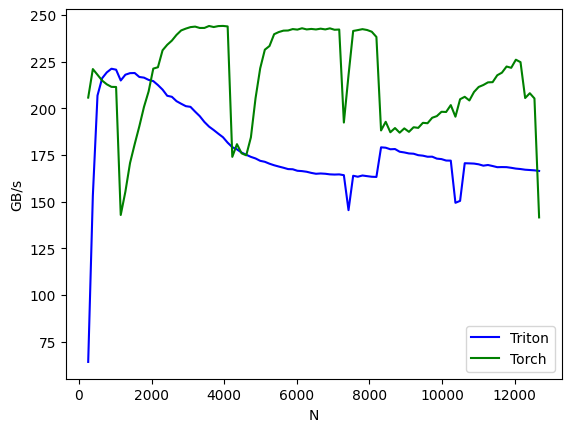

softmax-performance:
          N      Triton       Torch
0     256.0   64.221466  205.688660
1     384.0  153.203528  220.962364
2     512.0  206.801596  217.914153
3     640.0  216.060463  214.799942
4     768.0  219.180079  212.802103
5     896.0  221.147472  211.436188
6    1024.0  220.629782  211.377856
7    1152.0  214.854911  142.873486
8    1280.0  217.948222  155.352503
9    1408.0  218.777550  170.677057
10   1536.0  218.853550  180.777390
11   1664.0  216.736040  190.332441
12   1792.0  216.376049  200.699591
13   1920.0  215.171022  209.019196
14   2048.0  214.522395  221.206390
15   2176.0  212.406132  221.938237
16   2304.0  209.960932  231.021415
17   2432.0  206.670863  233.953765
18   2560.0  206.115395  236.195426
19   2688.0  203.782435  239.253357
20   2816.0  202.396634  241.644439
21   2944.0  201.108184  242.617878
22   3072.0  200.744592  243.412932
23   3200.0  198.177635  243.686633
24   3328.0  195.753460  242.960939
25   3456.0  192.640654  242.977516
26   35

In [16]:
#Benchmark code borrowed from Triton Docs

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)